<h1 style="text-align:center;font-size:40px;">Tools 1 Final Project</h1>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<p style="text-align:center;">Anthony Molieri<br>
Leo Walker</p>
<br>
<br>
<br>
<br>

# Dataset and Motivation

The data used for these analyses were scraped from Indeed and Glassdoor. The data from Indeed contains job descriptions for open Data Scientist positions. The Glassdoor data includes employee generated ratings on benefits and perks for many of the companies present in the Indeed dataset. The datasets were then combined in order to give an idea of how employees rank the benefits at these companies.

*The Indeed data was scraped over ... pulling job descriptions for Data Scientists in 25 cities throughout the US. **Leo** Add Correct Details, here about the Indded data and scraper*

The Glassdoor scraper was designed to pull company names from the the job description dataset. It then looped over the list of employers, searched, and scraped ratings from the benefits page for companies that were found. This data was then added to it's own table in the same database. The scraper was designed to be run multiple times, only searching for benefits ratings that were not already present in the database. 

# Task Definition and Research Question
 
The purpose of this project was to help give a better idea of how employees at companies with open positions rate their benefits. This can help give insight into how desirable a company is as an employer.

# Literature Review

*Add -- I'm not really sure what to add here. Maybe something about turnover in data science? Companies not having great benefits?*

# Data Cleaning

In [110]:
# imports
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import re


In [111]:
# Initialize both tables
cnct = sqlite3.connect('Data/jobs')

indeed_df = pd.read_sql_query('SELECT * FROM indeed_jobs;', cnct)

glassdoor_df = pd.read_sql_query('SELECT companies, type, rating, count_of_ratings FROM ratings;', cnct)

## Cleaning Indeed Data

In [112]:
# While we were able to get the estimated salary from the job scraping we can see if there was any job salaries within the job description
def salary_extract(row):
    if row['est_salary']!="No Estimated Salary":
        return row['est_salary']
    else:
        pattern = r"\$([0-9]{5,6}|[0-9]{2,3},[0-9]{3})"
        found = re.findall(pattern, row['job_desc'])
        if len(found)==1:
            return f'{found[0]} a year'
        elif len(found)>1:
            return f'{found[0]} - {found[1]} a year'
        else:
            return None

indeed_df['salary_extract'] = indeed_df.apply(salary_extract, axis=1)

In [113]:
# While we have the job title we need to categorize each job
def set_job_category(job_title):
    regex = re.compile('[^a-zA-Z]')
    clean_title = regex.sub('', job_title)
    clean_title = clean_title.lower()
    if all(x in clean_title for x in ["data", "scien"]):
        return "Data Scientist"
    elif all(x in clean_title for x in ["business", "analy"]):
        return "Business Intelligence Analyst"
    elif all(x in clean_title for x in ["bi", "analy"]):
        return "Business Intelligence Analyst"
    elif all(x in clean_title for x in ["data", "analy"]):
        return "Data Analyst"
    elif all(x in clean_title for x in ["machine", "learning"]):
        return "Machine Learning Engineer"
    elif all(x in clean_title for x in ["data", "engineer"]):
        return "Data Engineer"
    elif all(x in clean_title for x in ["software", "engin"]):
        return "Software Engineer"
    elif all(x in clean_title for x in ["architect"]):
        return "Data Architect"
    else:
        return "Other"

indeed_df['job_category'] = indeed_df.loc[:, 'job_title'].apply(set_job_category)

In [114]:
# Lets get the state from the company location so we can generalize them
indeed_df.loc[:,'state'] = indeed_df.loc[:, 'company_location'].str.extract(r', ([A-Z]{2})')

In [115]:
indeed_df.salary_extract

0        None
1        None
2        None
3        None
4        None
         ... 
17181    None
17182    None
17183    None
17184    None
17185    None
Name: salary_extract, Length: 17186, dtype: object

In [116]:
# We have the estimated salary but we need to parse out the min/low and max/high of the salary range so we can determine the average

def salary_low(row):
    if row ==None:
        return None
    salary = str(row).split('-')
    pattern = r'([0-9]+\.*,*[0-9]+)'
    low = float(''.join(re.findall(pattern, salary[0])).replace(',',''))
    return low

def salary_high(row):
    if row ==None:
        return None
    salary = str(row).split('-')
    pattern = r'([0-9]+\.*,*[0-9]+)'
    if len(salary)>1:
        high = float(''.join(re.findall(pattern, salary[1])).replace(',',''))
    else:
        high = float(''.join(re.findall(pattern, salary[0])).replace(',',''))
    return high

indeed_df.loc[:,['salary_low']] = indeed_df.loc[:,'salary_extract'].apply(salary_low)
indeed_df.loc[:,['salary_high']] = indeed_df.loc[:,'salary_extract'].apply(salary_high)

In [117]:
# We noticed that the pay rate varies between annual, month, week, day, or hour. 
def pay_rate(row):
    if row ==None:
        return None
    regex = re.compile('[.[0-9]]')
    clean_salary = regex.sub('', row)
    clean_salary = clean_salary.lower()
    if any(x in clean_salary for x in ["year"]):
        return "annual"
    elif any(x in clean_salary for x in ["month"]):
        return "month"
    elif any(x in clean_salary for x in ["week"]):
        return "week"
    elif any(x in clean_salary for x in ["day"]):
        return "day"
    elif any(x in clean_salary for x in ["hour"]):
        return "hour"
    else:
        return "Other"

indeed_df['pay_rate'] = indeed_df.loc[:, 'salary_extract'].apply(pay_rate)

In [118]:
def calc_salary(row):
    # print(row)
    pay_rate=row['pay_rate']
    if (pay_rate == 'Other') or (pay_rate==None):
        return None

    rate_change= {'annual':1, 'month':12, 'week':52, 'day':260, 'hour':2080}
    est_annual_salary = ((row['salary_low']+row['salary_high'])/2)*rate_change[pay_rate]
    return est_annual_salary
indeed_df['est_annual_salary'] = indeed_df.loc[:,['salary_low','salary_high','pay_rate']].apply(calc_salary, axis=1)

In [119]:
indeed_df[indeed_df['est_salary']!='No Estimated Salary'].sample(4)

,index,job_title,company_name,company_location,est salary,job_href,job_desc,est_salary,retrieve_date,salary_extract,job_category,state,salary_low,salary_high,pay_rate,est_annual_salary
4370,10,Senior Data Analyst / Data Architect,"Excelraise, LLC","Remote in Raleigh, NC",None,https://www.indeed.com/rc/clk?jk=b25fffba099ed...,Job Detail Job Code 676200 Tax Term W2 Hourly1...,$80 - $85 an hour,2022-02-19,$80 - $85 an hour,Data Analyst,NC,80.0,85.0,hour,171600.0
6388,9,Data Engineer,TRX,"Remote in Denver, CO",None,https://www.indeed.com/company/HELIX-HUMAN-CAP...,TRX is a global training brand that has create...,"$135,000 - $155,000 a year",2022-02-26,"$135,000 - $155,000 a year",Data Engineer,CO,135000.0,155000.0,annual,145000.0
10345,1,Software Engineer,State Farm,"Hybrid remote in Dunwoody, GA 30346",None,https://www.indeed.com/rc/clk?jk=bc05ba0728e13...,Overview: We are not just offering a job but ...,"$69,115 - $135,400 a year",2022-03-19,"$69,115 - $135,400 a year",Software Engineer,GA,69115.0,135400.0,annual,102257.5
13865,8,REPORTING DATA ANALYST (BUSINESS INTELLIGENCE ...,State of Arizona,"Remote in Phoenix, AZ 85021+1 location",None,https://www.indeed.com/rc/clk?jk=e3f54318c2257...,"The Department of Economic Security, Divis...","$59,971 - $84,163 a year",2022-04-04,"$59,971 - $84,163 a year",Business Intelligence Analyst,AZ,59971.0,84163.0,annual,72067.0


## Cleaning Glassdoor Data

In [120]:
# Restructure glassdoor data

# split type and sub-type
glassdoor_df[['new_type', 'sub_type']] = glassdoor_df['type'].str.split(' - ', expand=True)
glassdoor_df.drop(['type'], axis=1, inplace=True)

glassdoor_df.head()

,companies,rating,count_of_ratings,new_type,sub_type
0,Visa,3.7,157,"Insurance, Health & Wellness",Health Insurance
1,Visa,3.6,21,"Insurance, Health & Wellness",Dental Insurance
2,Visa,3.6,18,"Insurance, Health & Wellness",Vision Insurance
3,Visa,3.4,13,"Insurance, Health & Wellness",Life Insurance
4,Visa,3.0,7,"Insurance, Health & Wellness",Health Savings Account (HSA)


In [121]:
# Get rid of text from ratings counts. The original parser wasn't made to handle language other than English
glassdoor_df['count_of_ratings'] = glassdoor_df['count_of_ratings'].str.extract('(\d+)', expand=False)

# change rating and count of ratings to numeric
glassdoor_df['rating'] = glassdoor_df['rating'].astype(float)
glassdoor_df['count_of_ratings'] = glassdoor_df['count_of_ratings'].astype(int)

In [122]:
# get overall benefits scores

scaleScores = glassdoor_df.groupby(['companies', 'new_type']).apply(lambda x: (x["rating"]* x["count_of_ratings"]).sum() / x["count_of_ratings"].sum())

scaleScores.head(5)

companies        new_type                    
-Social Native-  Insurance, Health & Wellness    1.000000
                 Perks & Discounts               5.000000
1-800 Contacts   Family & Parenting              3.487500
                 Financial & Retirement          3.800000
                 Insurance, Health & Wellness    3.463636
dtype: float64

In [123]:
# get mean count of ratings
countScore = glassdoor_df.groupby(['companies']).apply(lambda x: (x["count_of_ratings"]).mean())

countScore.head(5)

companies
-Social Native-                       1.500000
1-800 Contacts                        2.483871
1199SEIU Benefit and Pension Funds    1.516129
1upHealth                             1.000000
22squared                             1.823529
dtype: float64

In [124]:
# Turn the calculated series' into dataframes that can be merged

# Scale Scores
scaleScore_temp = scaleScores.to_frame().reset_index()

scaleScore_df = scaleScore_temp.pivot_table(0, ['companies'], 'new_type')

scaleScore_df.reset_index( drop=False, inplace=True ) 
scaleScore_df.reindex(['companies', 'Family & Parenting', 'Financial & Retirement', 'Insurance, Health & Wellness', 'Perks & Discounts', 'Professional Support', 'Vacation & Time Off'], axis=1)

# Average of scores by
countScore_temp = countScore.to_frame().reset_index()
countScore_temp.rename(columns={0: "ratings_meanCount"}, inplace=True)

scaleScore_df = scaleScore_df.merge(countScore_temp, on='companies')

scaleScore_df

,companies,Family & Parenting,Financial & Retirement,"Insurance, Health & Wellness",Perks & Discounts,Professional Support,Vacation & Time Off,ratings_meanCount
0,-Social Native-,NaN,NaN,1.000000,5.000000,NaN,NaN,1.500000
1,1-800 Contacts,3.4875,3.800000,3.463636,4.140000,4.333333,3.363636,2.483871
2,1199SEIU Benefit and Pension Funds,2.7000,4.150000,2.857143,2.200000,2.000000,2.500000,1.516129
3,1upHealth,4.5000,2.000000,3.000000,3.000000,NaN,4.500000,1.000000
4,22squared,3.8000,2.725000,2.927273,3.333333,NaN,3.777778,1.823529
...,...,...,...,...,...,...,...,...
2343,pureIntegration,NaN,NaN,4.500000,NaN,NaN,NaN,2.000000
2344,the NBA,3.7500,3.800000,3.125000,3.484615,3.333333,2.400000,1.782609
2345,tunein,4.0000,NaN,3.000000,4.000000,NaN,NaN,1.000000
2346,us issworld,2.0000,2.500000,2.707692,NaN,1.000000,2.746667,3.200000


In [125]:
# Calculate a mean of all 6 categories
scaleScore_df['overall_mean'] = scaleScore_df[['Family & Parenting', 'Financial & Retirement', 'Insurance, Health & Wellness', 'Perks & Discounts', 'Professional Support', 'Vacation & Time Off']].mean(axis=1)

scaleScore_df.head(5)

,companies,Family & Parenting,Financial & Retirement,"Insurance, Health & Wellness",Perks & Discounts,Professional Support,Vacation & Time Off,ratings_meanCount,overall_mean
0,-Social Native-,NaN,NaN,1.000000,5.000000,NaN,NaN,1.500000,3.000000
1,1-800 Contacts,3.4875,3.800,3.463636,4.140000,4.333333,3.363636,2.483871,3.764684
2,1199SEIU Benefit and Pension Funds,2.7000,4.150,2.857143,2.200000,2.000000,2.500000,1.516129,2.734524
3,1upHealth,4.5000,2.000,3.000000,3.000000,NaN,4.500000,1.000000,3.400000
4,22squared,3.8000,2.725,2.927273,3.333333,NaN,3.777778,1.823529,3.312677


# Visualizations

### Glassdoor

#### Look at benefits ratings generally

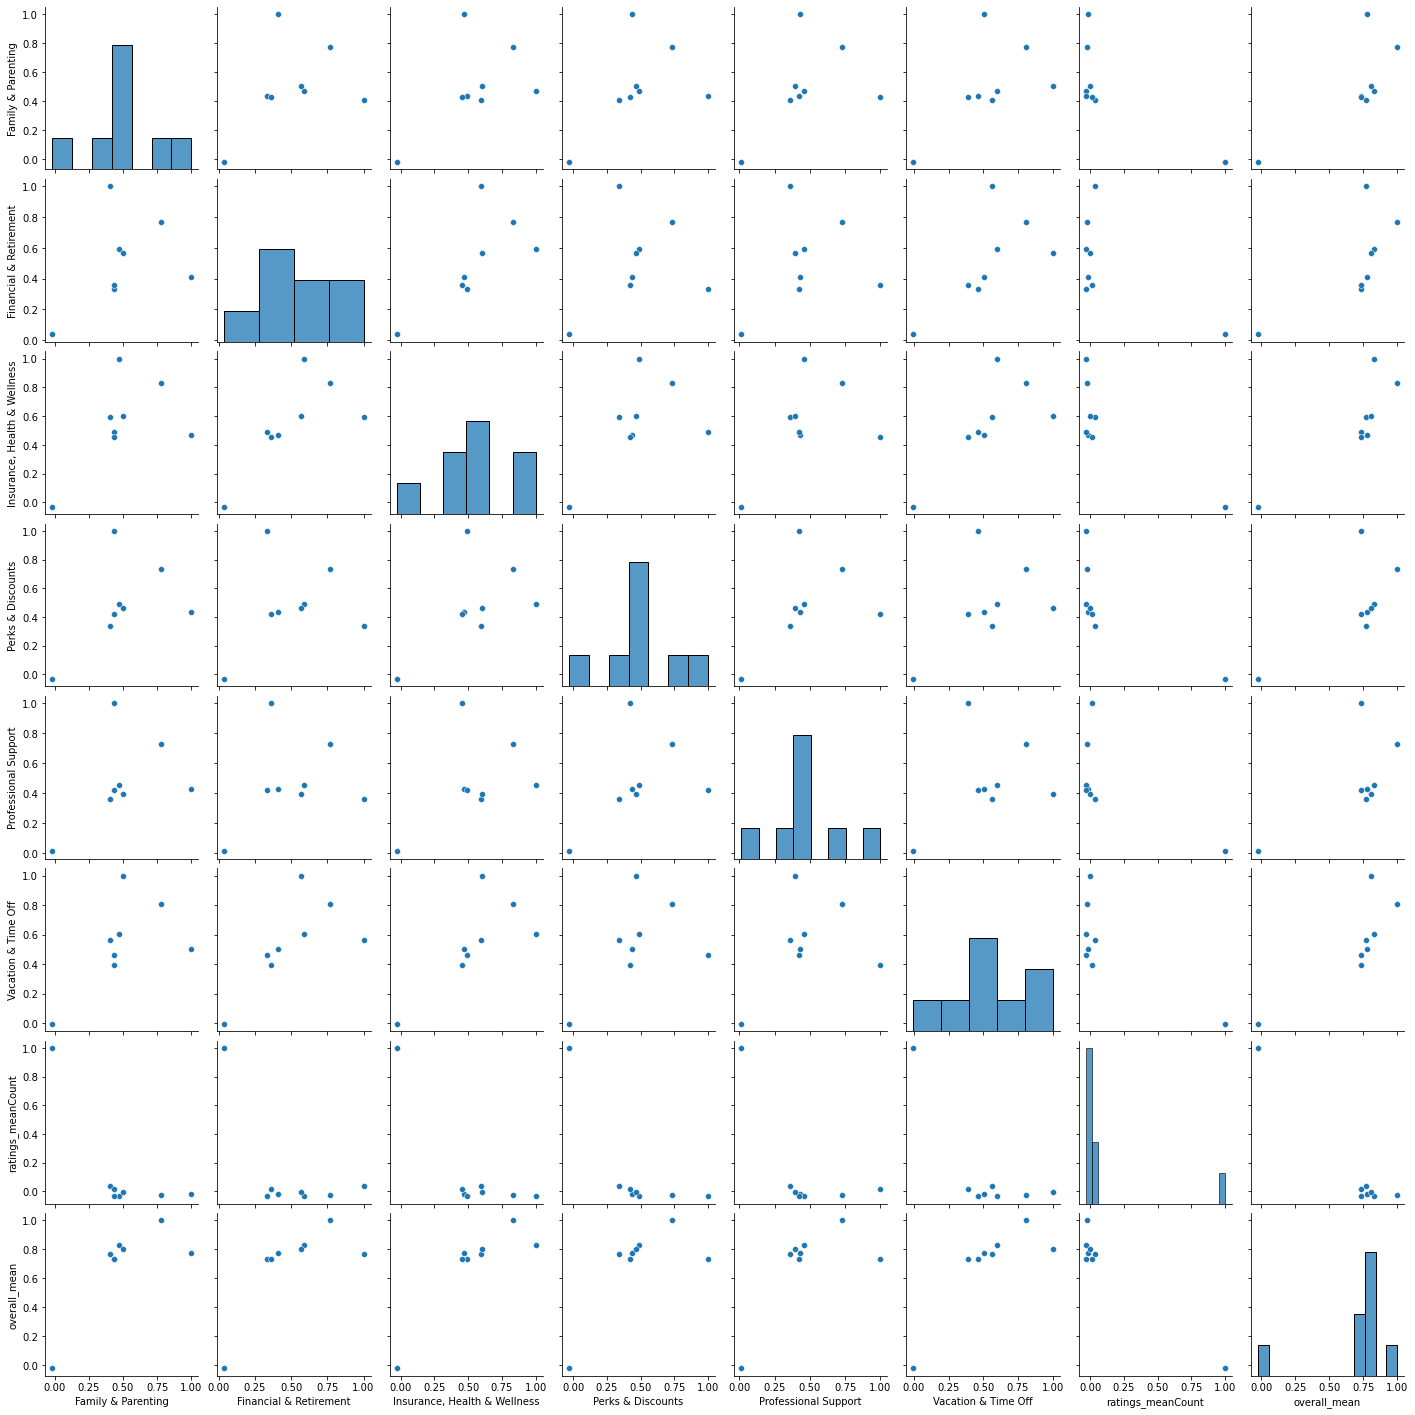

In [126]:
# Correlations on everything
sns.pairplot(scaleScore_df.corr())
plt.show()

In [127]:
glassdoor_df.head(10)

,companies,rating,count_of_ratings,new_type,sub_type
0,Visa,3.7,157,"Insurance, Health & Wellness",Health Insurance
1,Visa,3.6,21,"Insurance, Health & Wellness",Dental Insurance
2,Visa,3.6,18,"Insurance, Health & Wellness",Vision Insurance
3,Visa,3.4,13,"Insurance, Health & Wellness",Life Insurance
4,Visa,3.0,7,"Insurance, Health & Wellness",Health Savings Account (HSA)
5,Visa,2.8,6,"Insurance, Health & Wellness",Accidental Death & Dismemberment Insurance
6,Visa,2.8,6,"Insurance, Health & Wellness",Disability Insurance
7,Visa,3.2,5,"Insurance, Health & Wellness",Flexible Spending Account (FSA)
8,Visa,2.8,5,"Insurance, Health & Wellness",Mental Health Care
9,Visa,1.7,3,"Insurance, Health & Wellness",Supplemental Life Insurance


[]

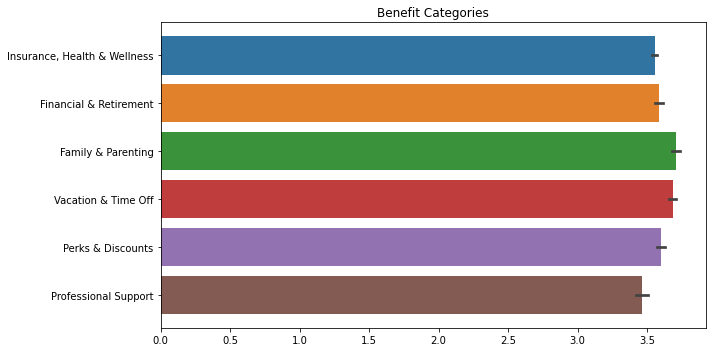

In [128]:
# Which benefit categories have the highest ratings?
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=glassdoor_df, y='new_type', x='rating').set(xlabel=None, ylabel=None, title='Benefit Categories')

plt.tight_layout()
plt.plot()

All categories have fairly high ratings. Lets look at subcategories by group.

[]

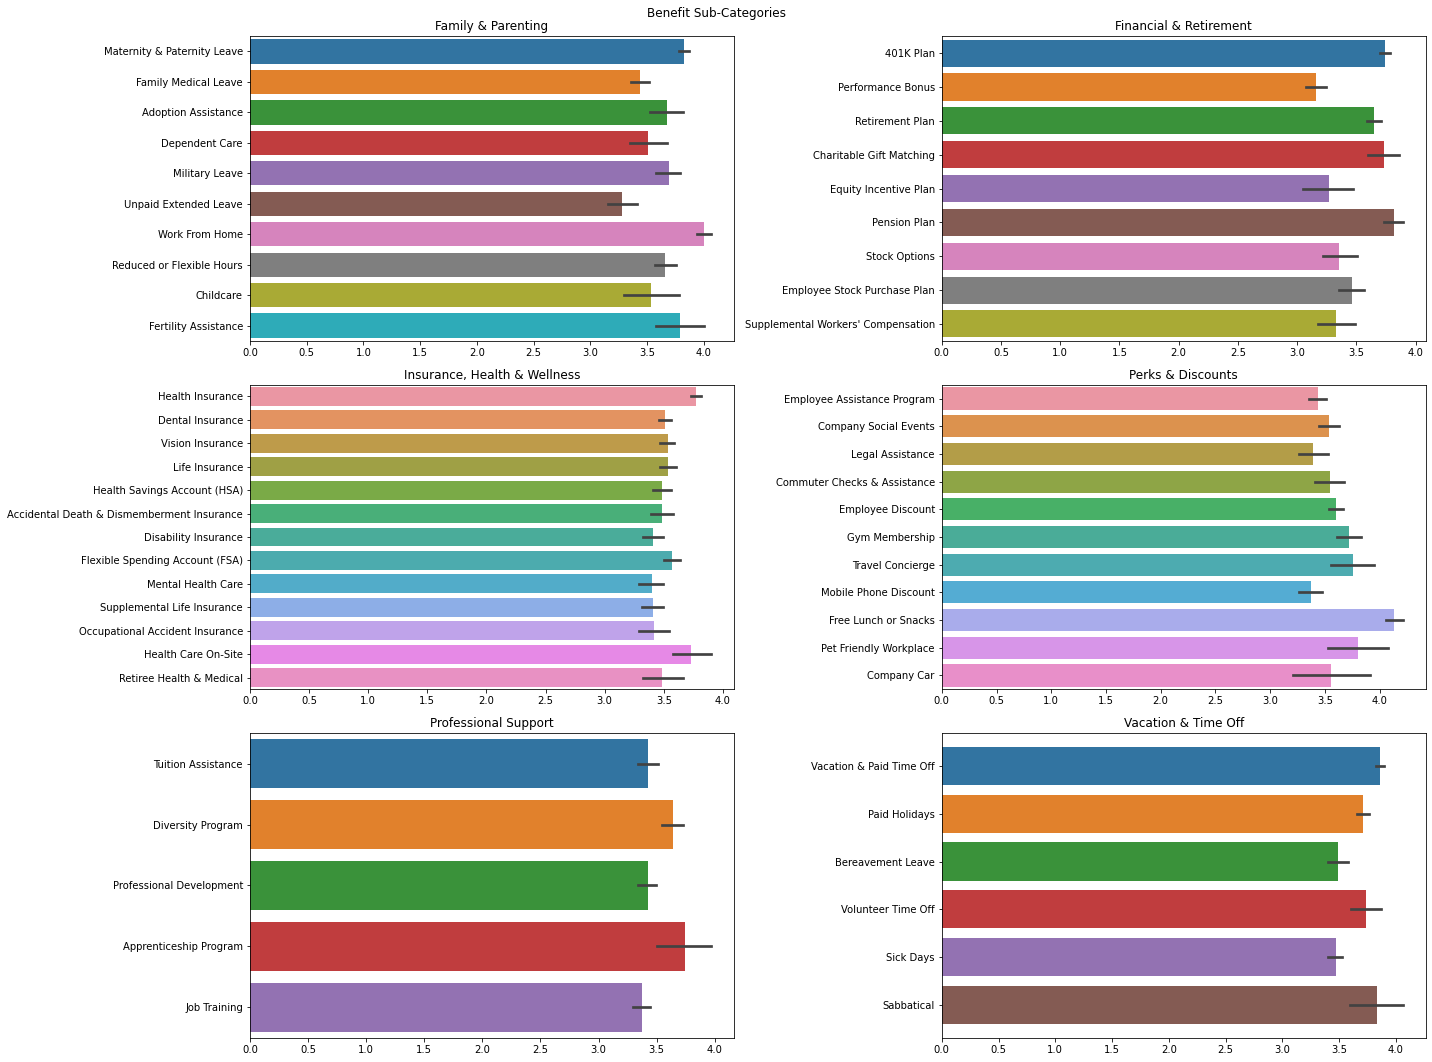

In [146]:
# Which benefit categories have the highest ratings?
fig, ax = plt.subplots(ncols=2 , nrows=3, figsize=(20, 15))
sns.barplot(data=glassdoor_df[glassdoor_df['new_type'] =='Family & Parenting'], y='sub_type', x='rating', ax=ax[0,0]).set(title='Family & Parenting', xlabel=None, ylabel=None)
sns.barplot(data=glassdoor_df[glassdoor_df['new_type'] =='Financial & Retirement'], y='sub_type', x='rating', ax=ax[0,1]).set(title='Financial & Retirement', xlabel=None, ylabel=None)
sns.barplot(data=glassdoor_df[glassdoor_df['new_type'] =='Insurance, Health & Wellness'], y='sub_type', x='rating', ax=ax[1,0]).set(title='Insurance, Health & Wellness', xlabel=None, ylabel=None)
sns.barplot(data=glassdoor_df[glassdoor_df['new_type'] =='Perks & Discounts'], y='sub_type', x='rating', ax=ax[1,1]).set(title='Perks & Discounts', xlabel=None, ylabel=None)
sns.barplot(data=glassdoor_df[glassdoor_df['new_type'] =='Professional Support'], y='sub_type', x='rating', ax=ax[2,0]).set(title='Professional Support', xlabel=None, ylabel=None)
sns.barplot(data=glassdoor_df[glassdoor_df['new_type'] =='Vacation & Time Off'], y='sub_type', x='rating', ax=ax[2,1]).set(title='Vacation & Time Off', xlabel=None, ylabel=None)
fig.suptitle('Benefit Sub-Categories')

plt.tight_layout()
plt.plot()

In [130]:
# Let's only look at the companies with the highest ratings (only including companies that have at least 10 ratings per category on average)
mostRated = scaleScore_df[scaleScore_df['ratings_meanCount'] >= 10].nlargest(10, 'overall_mean')

mostRated

,companies,Family & Parenting,Financial & Retirement,"Insurance, Health & Wellness",Perks & Discounts,Professional Support,Vacation & Time Off,ratings_meanCount,overall_mean
1978,The Hanover Insurance Group,5.000000,4.600000,4.300000,4.000000,NaN,4.800000,11.000000,4.540000
1723,Salesforce,4.733835,4.431048,4.582927,4.501852,4.100000,4.626250,27.666667,4.495985
900,Google,4.619463,4.601604,4.612454,4.659918,3.838462,4.388095,32.229167,4.453333
2069,UKG (Ultimate Kronos Group),4.632558,4.358273,4.484848,4.631250,4.063636,4.493694,16.157895,4.444043
1826,Southwest Airlines,4.273529,4.695477,4.358929,4.413115,4.547826,4.262376,15.837838,4.425209
1827,Southwest Airlines Co.,4.273529,4.695477,4.358929,4.413115,4.547826,4.262376,15.837838,4.425209
1392,New Relic,4.490909,3.880000,4.500000,5.000000,NaN,4.100000,11.000000,4.394182
189,AstraZeneca,4.206122,4.463235,4.035714,4.442857,4.800000,4.390909,10.260870,4.389806
160,Apple,4.555696,4.416726,4.486594,4.209366,4.284932,4.273571,62.913043,4.371147
1213,MIT,3.846429,4.390566,4.390977,4.087500,4.618182,4.350000,11.592593,4.280609


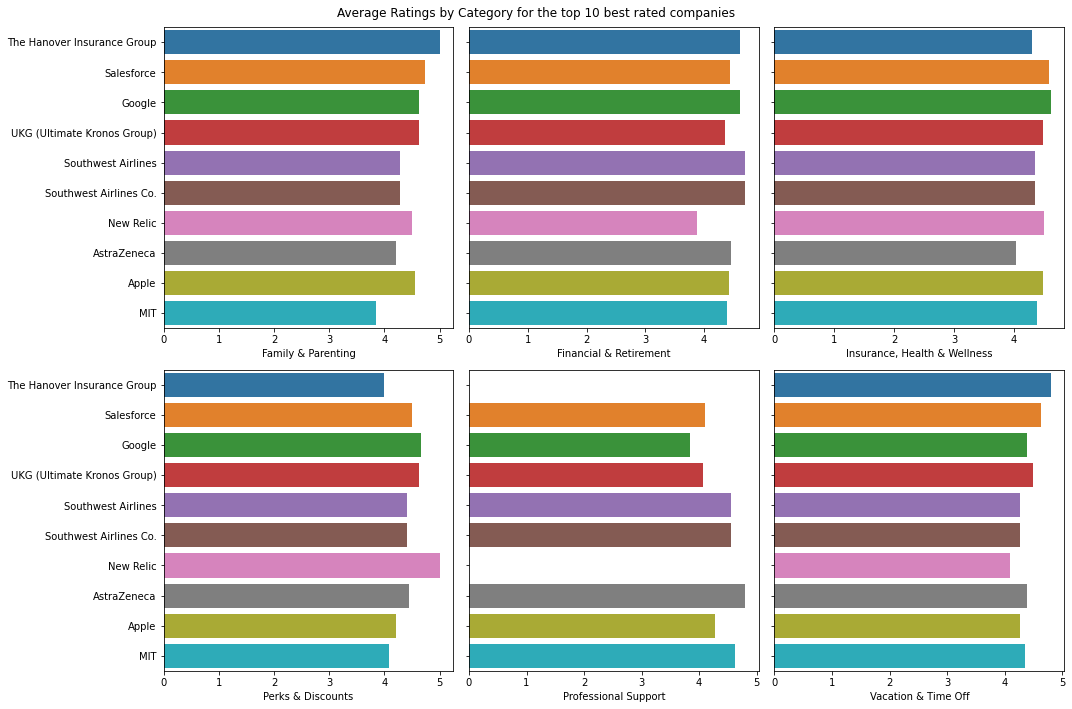

In [131]:
# Best Ratings by Category for the top 10 best rated companies
fig, ax = plt.subplots(ncols=3 , nrows=2, sharey=True, figsize=(15, 10))
sns.barplot(data=mostRated, x='Family & Parenting', y='companies', ax=ax[0,0]).set(ylabel=None)
sns.barplot(data=mostRated, x='Financial & Retirement', y='companies', ax=ax[0,1]).set(ylabel=None)
sns.barplot(data=mostRated, x='Insurance, Health & Wellness', y='companies', ax=ax[0,2]).set(ylabel=None)
sns.barplot(data=mostRated, x='Perks & Discounts', y='companies', ax=ax[1,0]).set(ylabel=None)
sns.barplot(data=mostRated, x='Professional Support', y='companies', ax=ax[1,1]).set(ylabel=None)
sns.barplot(data=mostRated, x='Vacation & Time Off', y='companies', ax=ax[1,2]).set(ylabel=None)
fig.suptitle('Average Ratings by Category for the top 10 best rated companies')

plt.tight_layout()
plt.show()

Different companies have different strengths regarding their ratings on each category. 

### Look at benefits ratings for companies 

In [132]:
# By companies with the most job postings

compCounts = indeed_df['company_name'].value_counts().to_frame()
compCounts.columns = ['count_of_jobs']

# Create groups for the job counts
compCounts['bins'] = pd.cut(compCounts['count_of_jobs'], bins=10)

compCounts

,count_of_jobs,bins
Deloitte,483,"(434.8, 483.0]"
Amazon.com Services LLC,359,"(338.4, 386.6]"
PRICE WATERHOUSE COOPERS,316,"(290.2, 338.4]"
"JPMorgan Chase Bank, N.A.",309,"(290.2, 338.4]"
Accenture,298,"(290.2, 338.4]"
...,...,...
BCD Travel Corporate,1,"(0.518, 49.2]"
Zimmer Biomet,1,"(0.518, 49.2]"
UF Jacksonville,1,"(0.518, 49.2]"
Axos Clearing LLC,1,"(0.518, 49.2]"


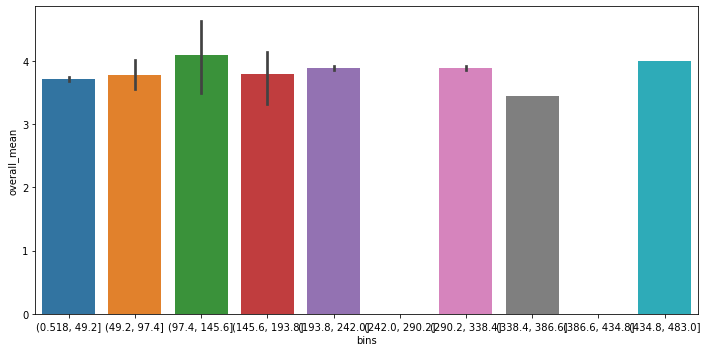

In [133]:
# See if companies with more job openings have better or worse overall ratings

openings_df = scaleScore_df.merge(compCounts, how='left', left_on='companies', right_on=compCounts.index)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='bins', y='overall_mean', data=openings_df)

plt.tight_layout()
plt.show()

For the most part ratings are fairly high. Companies with fewer job openings appear to have more variability in their ratings

In [134]:
indeed_df.sample(4)

,index,job_title,company_name,company_location,est salary,job_href,job_desc,est_salary,retrieve_date,salary_extract,job_category,state,salary_low,salary_high,pay_rate,est_annual_salary
16529,9,Principal Data Scientist,Lowe's,"Cary, NC 27513",None,https://www.indeed.com/rc/clk?jk=f96baab0cca7a...,Job Summary: The primary purpose of this ro...,No Estimated Salary,2022-04-11,None,Data Scientist,NC,NaN,NaN,None,NaN
1804,9,Senior Data Scientist - NLP,Deloitte,"Remote in Boston, MA+1 location",None,https://www.indeed.com/rc/clk?jk=3c4b8ceed426a...,Senior Data Scientist - NLP Location: Remote ...,No Estimated Salary,2022-02-12,None,Data Scientist,MA,NaN,NaN,None,NaN
10241,2,DATA ENGINEER,"Hyatt Corporate Office, Chicago","Chicago, IL",None,https://www.indeed.com/rc/clk?jk=3f9a7f6b85789...,"Summary The Opportunity At Hyatt, we’re worki...",No Estimated Salary,2022-03-19,None,Data Engineer,IL,NaN,NaN,None,NaN
1835,10,Sports Statistician,Life Time,"Denver, CO 80246 (Southeastern Denver area)",None,https://www.indeed.com/rc/clk?jk=1e35828f050ec...,"As a wellness pioneer, Life Time is reshaping ...",Up to $13.56 an hour,2022-02-12,Up to $13.56 an hour,Other,CO,13.56,13.56,hour,28204.8


In [135]:
scaleScore_df.sample(4)

,companies,Family & Parenting,Financial & Retirement,"Insurance, Health & Wellness",Perks & Discounts,Professional Support,Vacation & Time Off,ratings_meanCount,overall_mean
1942,Techpoint LLC,NaN,5.00,3.000000,NaN,NaN,NaN,1.500000,4.000000
678,DriveCentric,NaN,NaN,5.000000,NaN,NaN,NaN,1.000000,5.000000
1493,PEMCO,NaN,4.90,5.000000,NaN,NaN,4.500000,2.750000,4.800000
927,HDR,4.555556,4.48,4.451111,5.0,4.6,4.238095,3.538462,4.554127


In [136]:
#Let's merge the glassdoor and linked in dataframes
combined_df= indeed_df.merge(scaleScore_df, left_on='company_name', right_on='companies', how='left')

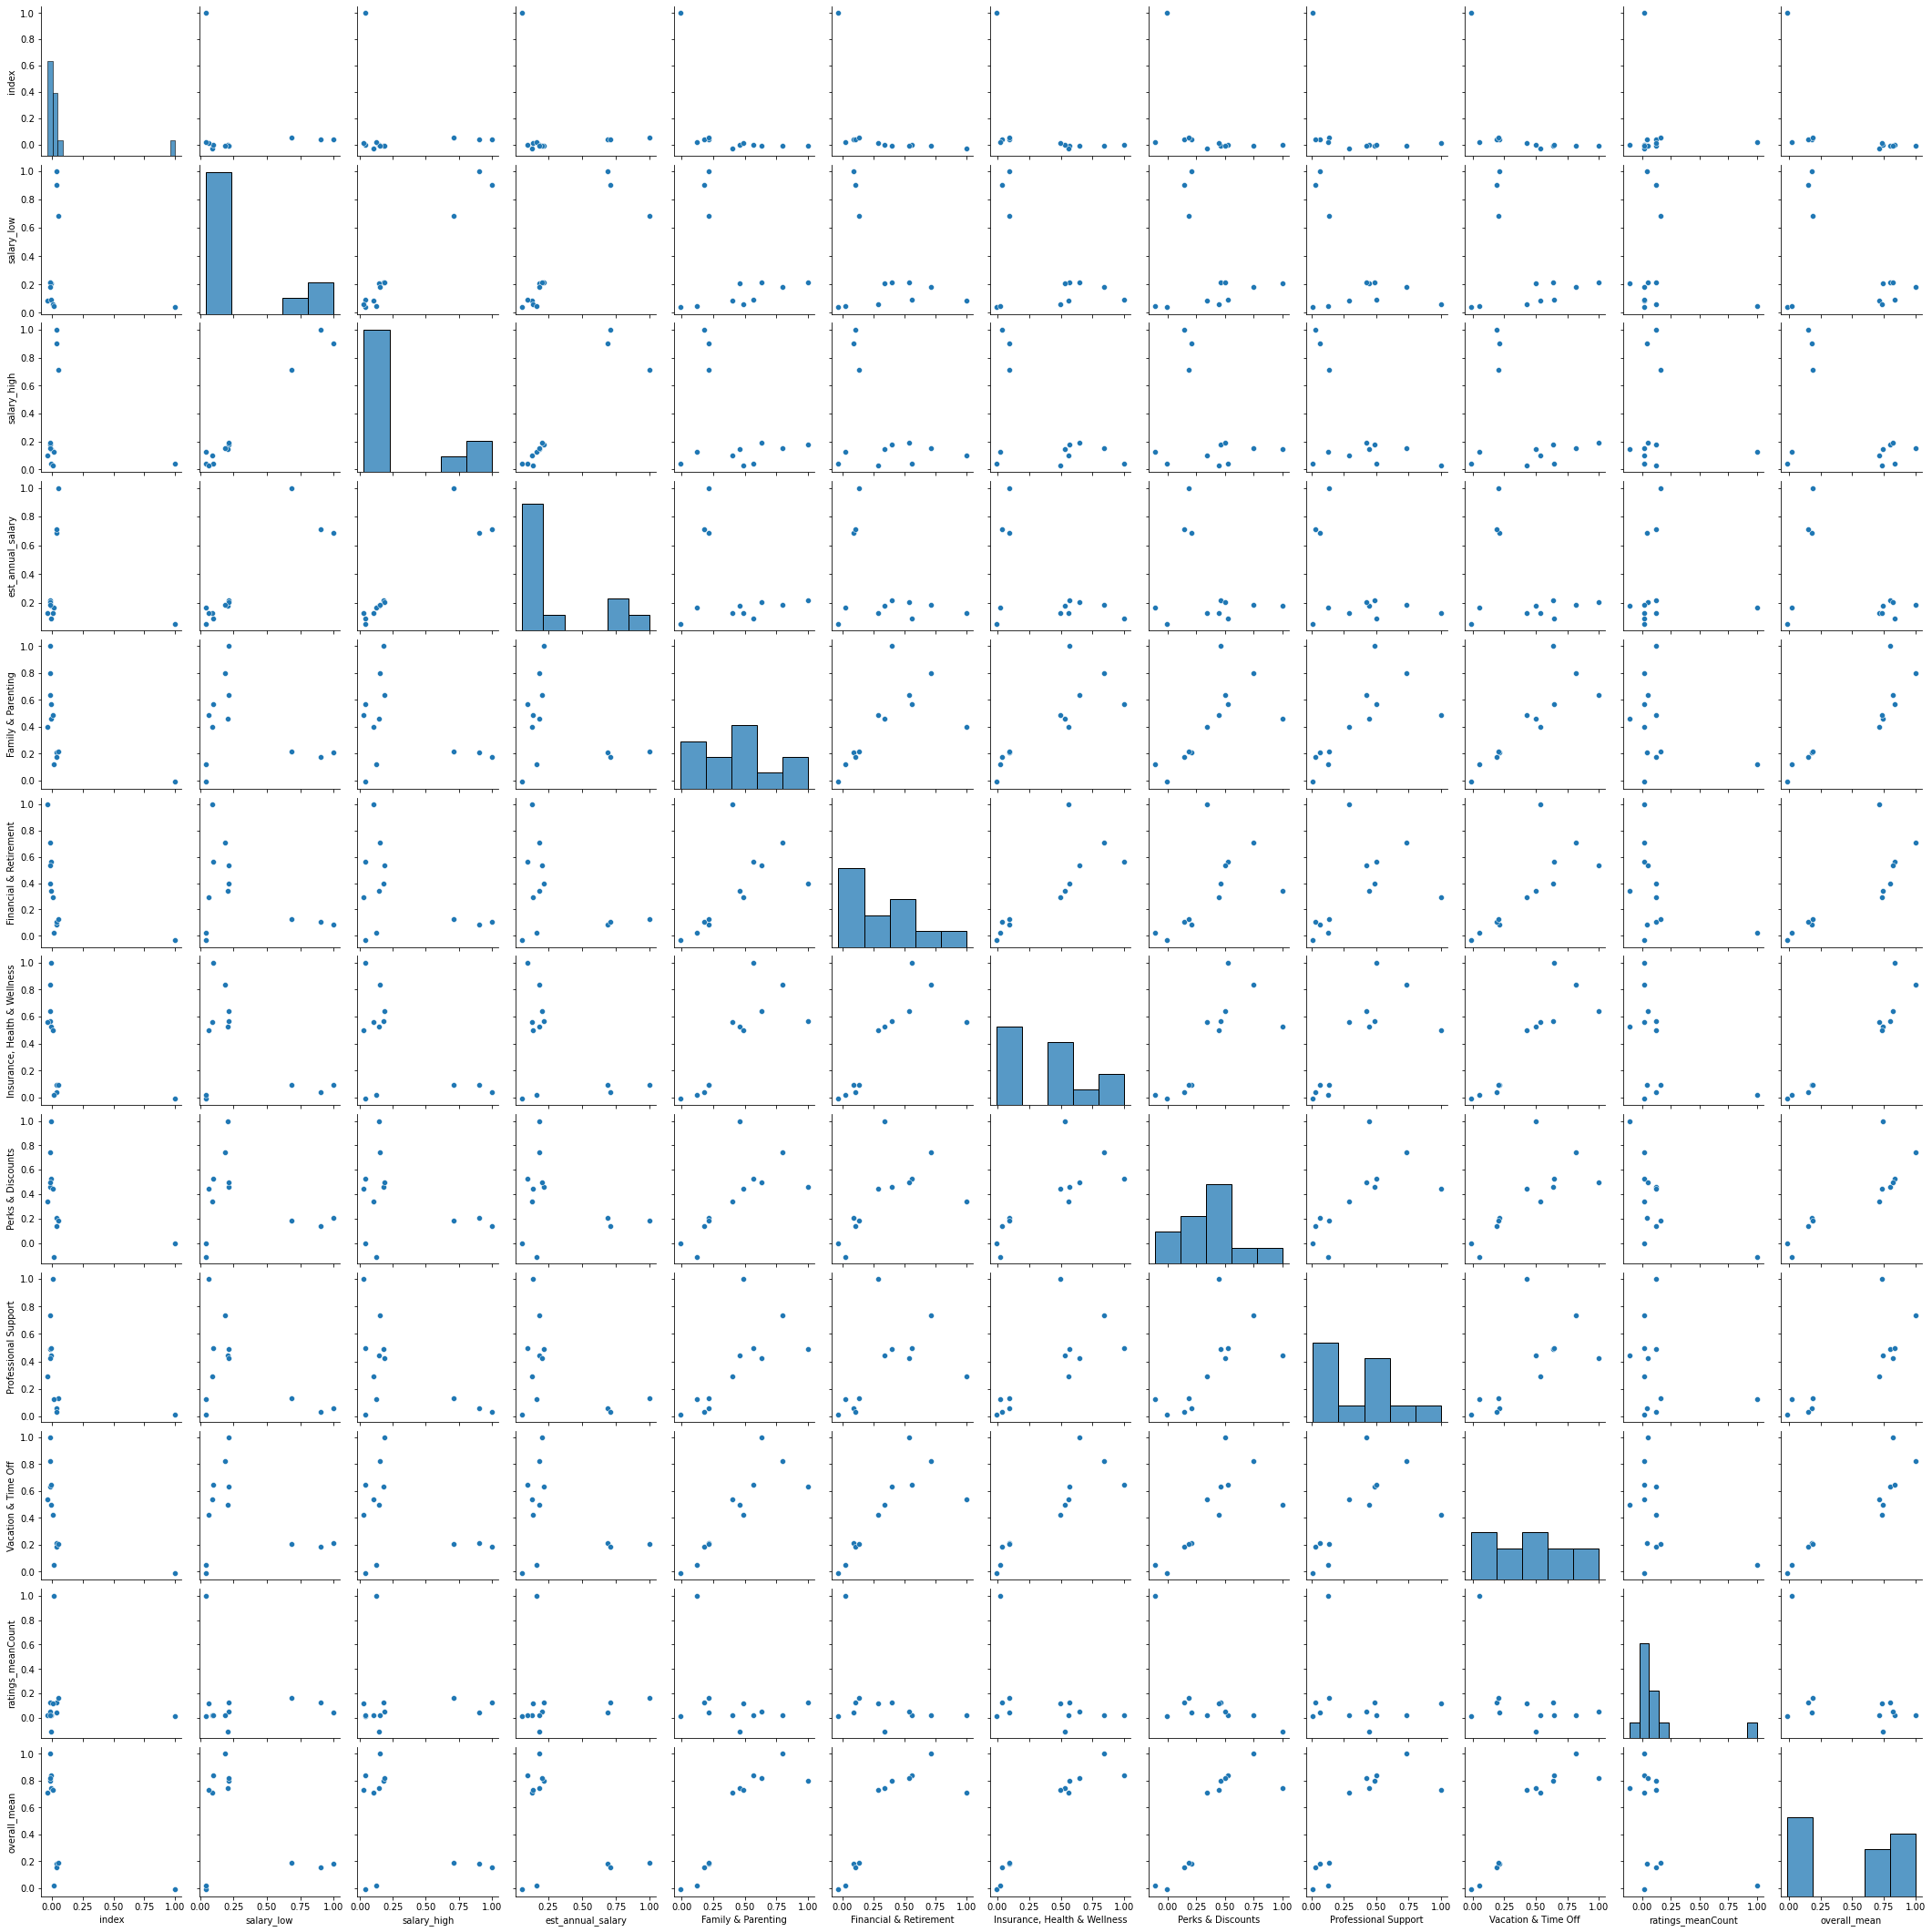

In [137]:
# check correlations with the combined datasets

sns.pairplot(combined_df.corr())
plt.show()

Nothing really stands out from these correlations

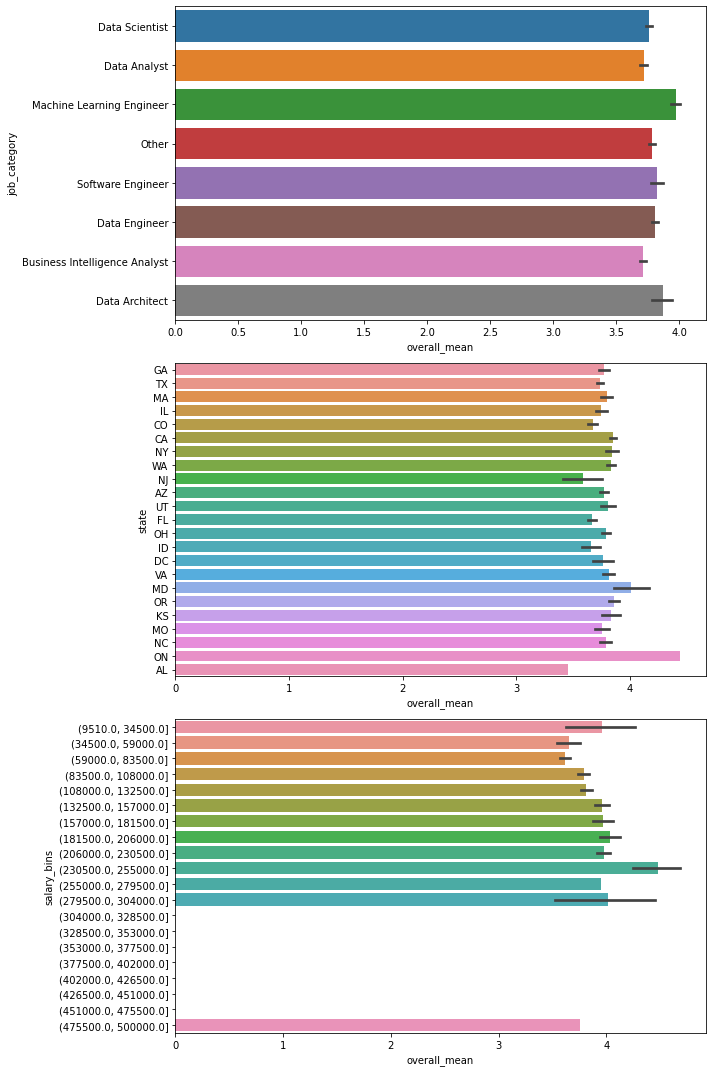

In [144]:
# Look at ratings by job category, state, and estimated annual salary

# Create groups for salary
combined_df['salary_bins'] = pd.cut(combined_df['est_annual_salary'], bins=20)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
sns.barplot(x='overall_mean', y='job_category', data=combined_df, ax=ax[0])
sns.barplot(x='overall_mean', y='state', data=combined_df, ax=ax[1])
sns.barplot(x='overall_mean', y='salary_bins', data=combined_df, ax=ax[2])

plt.tight_layout()
plt.show()

- Machine Learning Engineer and Data Architect appear to be titles common to more highly rated companies. 

- Of all locations in the dataset Ontario (ON?) looks to have companies with much higher ratings than anyplace in the states. This should be investigated as it may be only one company...

- Ratings based on salary are similar